In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import cv2
from skimage.feature import hog

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

# Lendo e tratando dados

In [2]:
def process_image(image_path):
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    return img_array

In [3]:
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            img_binary = process_image(img_path)
            images.append(img_binary.flatten())
    return images

In [4]:
def load_strings_from_folder(folder_path):
    strings = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r') as file:
                    content = file.read().strip()
                    strings.append(content)
                    filenames.append(filename)
            except Exception as e:
                print(f"Erro ao ler o arquivo {file_path}: {e}")
    return strings, filenames

In [5]:
treinamento = load_images_from_folder('dados/CAPTCHA-10k/treinamento')
treinamento = np.array(treinamento)
validacao = load_images_from_folder('dados/CAPTCHA-10k/validacao')
validacao = np.array(validacao)
teste = load_images_from_folder('dados/CAPTCHA-10k/teste')
teste = np.array(teste)
labels = load_strings_from_folder('dados/CAPTCHA-10k/labels10k')[0]

In [6]:
treino_x = treinamento
treino_y = labels[:8000]

validacao_x = validacao
validacao_y = labels[8000:9000]

teste_x = teste
teste_y = labels[9000:]

In [7]:
def print_img(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.show()

In [8]:
def apply_unsharp_mask(image, kernel_size=(5, 5), sigma=1.5):
    kernel = np.array([[0, -1, 0],
                       [-1, 6,-1],
                       [0, -1, 0]])
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = cv2.filter2D(blurred, -1, kernel)
    
    return sharpened

In [17]:
def particionar_img(image_array):
    image_array = np.reshape(image_array, (50, 180))
    # print_img(image_array)
    particoes = []
    offset = 30
    for i in range(0, 6):
        particao = image_array[10: 46, 5+offset*i:45+offset*i]
        particoes.append(particao)
        particao = apply_unsharp_mask(particao)
        # print_img(particao)
    particoes[5] = np.pad(particoes[5], ((0, 0), (7, 8)), 'constant', constant_values=255)
    return particoes

In [21]:
def aplicar_particao(images):
    images_particionadas = []
    for i in range(len(images)):
        images_particionadas.extend(particionar_img(images[i]))
    return np.array(images_particionadas)

In [22]:
def particonar_strings(strings):
    strings_particionadas = []
    for i in range(0, len(strings)):
        for j in range(0, 6):
            strings_particionadas.append(strings[i][j])
    
    return np.array(strings_particionadas)

In [23]:
set_caracteres = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?',
                  'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                  'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(set_caracteres)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

char_to_int = dict((c, i) for i, c in enumerate(set_caracteres))
int_to_char = dict((i, c) for i, c in enumerate(set_caracteres))

In [24]:
X_train = aplicar_particao(treino_x)
X_test = aplicar_particao(teste_x)
X_val = aplicar_particao(validacao_x)

y_train = particonar_strings(treino_y)
y_test = particonar_strings(teste_y)
y_val = particonar_strings(validacao_y)

In [25]:
y_train_int = label_encoder.transform(y_train)
y_test_int = label_encoder.transform(y_test)
y_val_int = label_encoder.transform(y_val)

y_train_onehot = onehot_encoder.transform(y_train_int.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test_int.reshape(-1, 1))
y_val_onehot = onehot_encoder.transform(y_val_int.reshape(-1, 1))

# HOG

In [31]:
def extract_hog_features(images):
    hog_features = []
    for image in images:
        fd, hog_image = hog(image, orientations=16, pixels_per_cell=(9, 10),
                            cells_per_block=(1, 1), visualize=True)
        hog_features.append(fd)
    return np.array(hog_features)

In [32]:
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)
X_val_hog = extract_hog_features(X_val)

## Classificador SVM

In [33]:
model_svm = svm.SVC(kernel='linear')
model_svm.fit(X_train_hog, y_train_int)

SVC(kernel='linear')

In [73]:
y_pred_svm = model_svm.predict(X_test_hog)
print("Accuracy:", accuracy_score(y_test_int, y_pred_svm))

accuracy_vector_svm = (y_pred_svm == y_test_int).astype(int)


Accuracy: 0.7846666666666666


## Classificador NN

In [36]:
input_shape = (256, 1)
num_classes = 37

model_nn = Sequential()
model_nn.add(Flatten(input_shape=(256, 1)))
model_nn.add(Dense(128, activation='relu'))
model_nn.add(Dropout(0.4))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dropout(0.4))
model_nn.add(Dense(num_classes, activation='softmax'))

model_nn.summary()
model_nn.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 37)                2405      
                                                                 
Total params: 43,557
Trainable params: 43,557
Non-traina

In [37]:
model_nn.fit(X_train_hog, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_val_hog, y_val_onehot))

Epoch 1/10
1500/1500 [==============================] - 7s 4ms/step - loss: 1.9515 - accuracy: 0.4188 - val_loss: 1.0430 - val_accuracy: 0.6895
Epoch 2/10
1500/1500 [==============================] - 8s 5ms/step - loss: 1.2029 - accuracy: 0.6215 - val_loss: 0.9199 - val_accuracy: 0.7170
Epoch 3/10
1500/1500 [==============================] - 9s 6ms/step - loss: 1.0786 - accuracy: 0.6620 - val_loss: 0.8322 - val_accuracy: 0.7375
Epoch 4/10
1500/1500 [==============================] - 11s 7ms/step - loss: 1.0174 - accuracy: 0.6796 - val_loss: 0.8173 - val_accuracy: 0.7418
Epoch 5/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.9744 - accuracy: 0.6947 - val_loss: 0.7849 - val_accuracy: 0.7538
Epoch 6/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.9344 - accuracy: 0.7053 - val_loss: 0.7742 - val_accuracy: 0.7595
Epoch 7/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.9073 - accuracy: 0.7142 - val_loss: 0.7803 - val_accuracy

In [74]:
y_pred_nn = model_nn.predict(X_test_hog)
y_pred_classes_nn = np.argmax(y_pred_nn, axis=1)
y_true_nn = np.argmax(y_test_onehot, axis=1)

accuracy_vector_nn = (y_pred_classes_nn == y_true_nn).astype(int)

print("Accuracy:", accuracy_score(y_true, y_pred_classes_nn))

188/188 [==============================] - 1s 6ms/step
Accuracy: 0.769


# CNN

In [69]:
input_shape = (36, 40, 1)
num_classes = 37

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='Same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='Same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

# model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [75]:
model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_val, y_val_onehot))

Epoch 1/10
1500/1500 [==============================] - 15s 9ms/step - loss: 1.5141 - accuracy: 0.6665 - val_loss: 0.1872 - val_accuracy: 0.9513
Epoch 2/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3897 - accuracy: 0.8825 - val_loss: 0.1446 - val_accuracy: 0.9612
Epoch 3/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2974 - accuracy: 0.9113 - val_loss: 0.1437 - val_accuracy: 0.9603
Epoch 4/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2586 - accuracy: 0.9225 - val_loss: 0.1341 - val_accuracy: 0.9652
Epoch 5/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2279 - accuracy: 0.9326 - val_loss: 0.1356 - val_accuracy: 0.9658
Epoch 6/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2024 - accuracy: 0.9384 - val_loss: 0.1305 - val_accuracy: 0.9698
Epoch 7/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1785 - accuracy: 0.9448 - val_loss: 0.1376 - val_ac

In [49]:
loss, accuracy = model.evaluate(X_test, y_test_onehot)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

188/188 [==============================] - 1s 6ms/step - loss: 0.1539 - accuracy: 0.9638
Test Loss: 0.15390545129776
Test Accuracy: 0.9638333320617676


In [76]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Gerar vetor de 0s e 1s indicando acertos (1) e erros (0)
accuracy_vector_cnn = (y_pred_classes == y_true).astype(int)

188/188 [==============================] - 1s 2ms/step


# Avaliando modelos

In [78]:
def gerar_freq(accuracy_vector):
    caracteres_reconhecidos = np.zeros(7)
    for i in range(0, 1000):
        soma = 0
        for j in range(0, 6):
            if accuracy_vector[i * 6 + j] == 1:
                soma += 1
        
        caracteres_reconhecidos[soma] += 1

    frequencias = np.zeros(7)
    for i in range(0, 7):
        frequencia = 0
        for j in range(i, 7):
            frequencia += caracteres_reconhecidos[j]
        frequencias[i] = frequencia
    frequencias = frequencias/1000

    return frequencias

In [58]:
def print_grafico(frequencias):
    x_values = [0, 1, 2, 3, 4, 5, 6]
    plt.figure(figsize=(10, 5))
    plt.plot(x_values, frequencias)

    plt.title('Resultado')
    plt.xlabel('Número mínimo de caracteres reconhecidos por captcha')
    plt.ylabel('Taxa de Reconhecimento')
    plt.ylim(0, 1.1)
    plt.grid(True)

    plt.show()

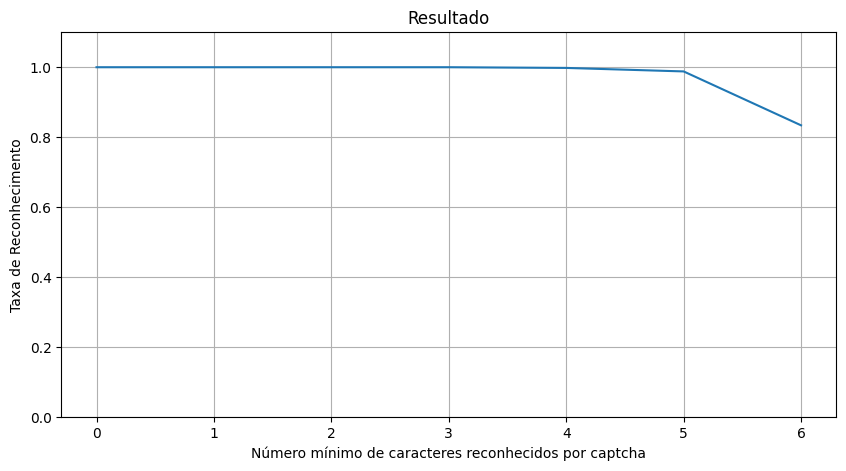

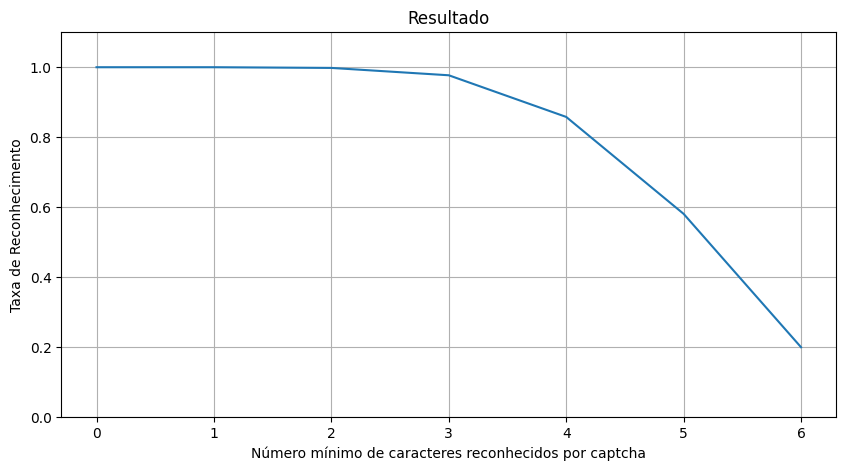

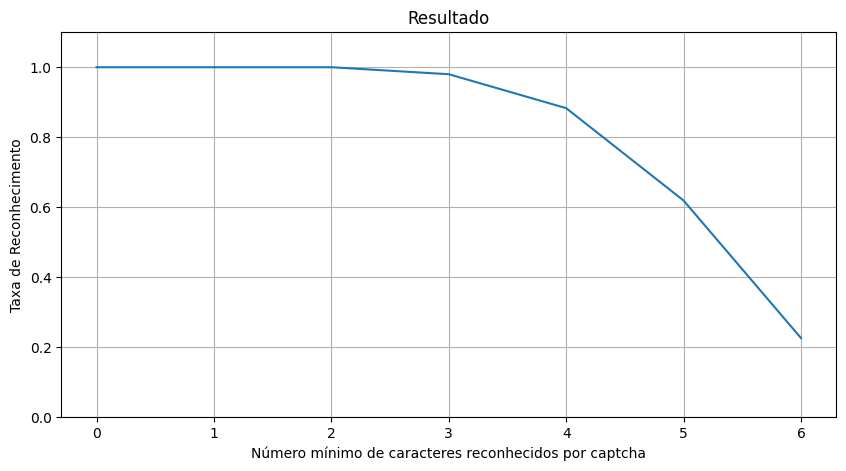

In [79]:
freq_cnn = gerar_freq(accuracy_vector_cnn)
freq_nn = gerar_freq(accuracy_vector_nn)
freq_svm = gerar_freq(accuracy_vector_svm)

print_grafico(freq_cnn)
print_grafico(freq_nn)
print_grafico(freq_svm)